In [4]:
import mthree

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit.visualization import plot_circuit_layout
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_aer
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

import numpy as np
from matplotlib import pyplot as plt

# Functions

In [5]:
def split_quasi_dist(qubit_subgroups, quasi_dist):
    """
    Split bitstrings in quasidistribution "quasi_dist" obtained from an IBM quantum computer to multiple quasidistribution for subgroups of smaller number of qubits provided by qubit_subgroups.
    The function allows to postproccess result for a request to real IBM device to run multiple small circuits in parallel.

    Parameters:
    - qubit_subgroups (list of lists): Each sublist contains the indices of qubits in the subgroup.
    - quasi_dist (dict): The results dictionary obtained from request to IBM device, with bitstrings as keys and shot counts as values.

    Returns:
    - List[dict]: A list of dictionaries, similar to imput "quasi_dist", each representing the results for a qubit subgroup.
    """
    # Initialize a list of dictionaries to hold the results for each subgroup
    subgroup_quasi_dist = [{} for _ in qubit_subgroups]

    # Iterate over each result in the original results dictionary
    for bitstring, count in quasi_dist.items():
        # For each subgroup, extract the relevant bits and add the count
        for i, subgroup in enumerate(qubit_subgroups):
            # Extract the bits relevant to the current subgroup
            subgroup_bitstring = ''.join(bitstring[index] for index in subgroup)
            # Add the count to the corresponding bitstring in the subgroup's results
            if subgroup_bitstring in subgroup_quasi_dist[i]:
                subgroup_quasi_dist[i][subgroup_bitstring] += count
            else:
                subgroup_quasi_dist[i][subgroup_bitstring] = count

    return subgroup_quasi_dist

import mthree
def mesurement_error_mitigation(qubit_subgroup, quasi_dist, backend):
    '''
    Measurement error mitigation rutine. Apply error mitigation to quasidistribution "quasi_dist" based of a noise model in "backend" corresponding to qubits in "qubit_subgroup".
    '''
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(qubit_subgroup)
    
    quasis = mit.apply_correction(quasi_dist, qubit_subgroup, return_mitigation_overhead=True)
    return quasis


from qiskit.result import QuasiDistribution
def quasidist_bits_to_array(quasi_dist, N_qubits):
    '''
    Convert the quasidistribution disctionary to a 2^N_qubits probabilies vector, 
    sorting and filling the missing entries.
    '''
    quasi_dist = QuasiDistribution(quasi_dist)
    
    probs_array = np.zeros(2**N_qubits)
    inds = np.array(list(quasi_dist.keys()))
    vals = np.array(list(quasi_dist.values()))
    probs_array[inds] = vals
    
    return probs_array

def sum_distributions(distributions):
    """
    Sums multiple quantum state probability distributions into a single distribution.
    
    Parameters:
    - distributions (list of dict): A list where each element is a dictionary representing
                                    a quantum state probability distribution.
    
    Returns:
    - dict: A single dictionary representing the summed probability distribution.
    """
    # Initialize an empty dictionary for the summed distribution
    summed_distribution = {}

    n = len(distributions)
    
    # Iterate over each distribution in the list
    for distribution in distributions:
        # Iterate over each quantum state and its probability in the current distribution
        for state, probability in distribution.items():
            # Normalise
            probability/=n
            # If the quantum state is already in the summed distribution, add the probability
            if state in summed_distribution:
                summed_distribution[state] += probability
            # Otherwise, add the state and probability to the summed distribution
            else:
                summed_distribution[state] = probability
                
    return summed_distribution

# Setup IBM service and simulators

In [16]:
service = QiskitRuntimeService(channel="ibm_quantum", 
                               token="<MY_IBM_QUANTUM_TOKEN>"
                              )

backend_brisbane = service.backend("ibm_brisbane")
backend_sim_brisbane = AerSimulator.from_backend(backend_brisbane

backend_sim_air      = qiskit_aer.Aer.get_backend('aer_simulator')

sampler_sim_brisbane = BackendSampler(backend_sim_brisbane)
sampler_sim_air = BackendSampler(backend_sim_air)

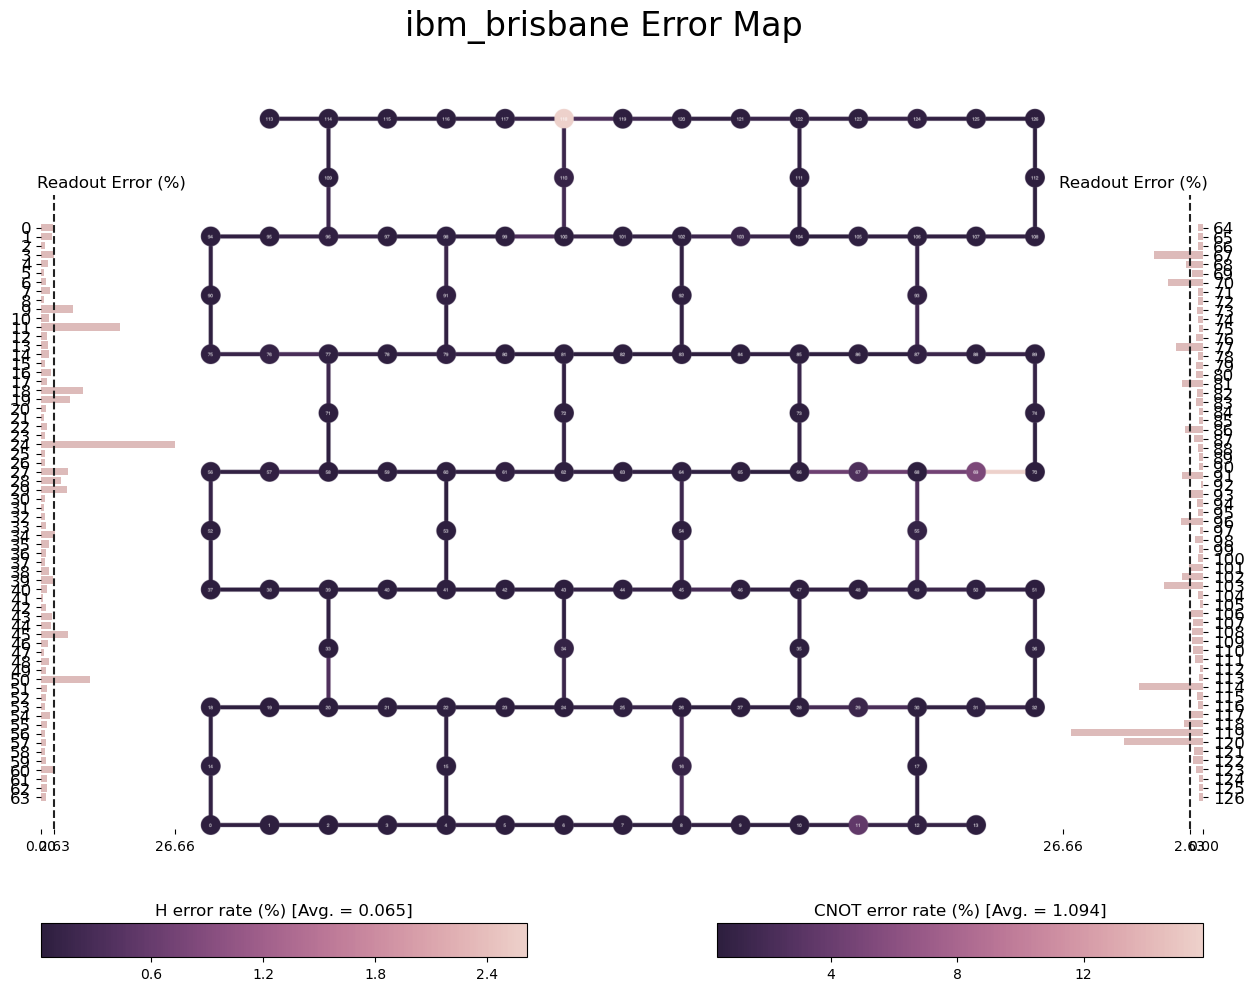

In [11]:
from qiskit.visualization import plot_error_map
plot_error_map(backend_brisbane)

In [17]:
# Indices of qubuits arranged in snake-like order to sequentially fit cirquits
snake_qubit_inds = np.concatenate(
    [np.arange(13,-1,-1), [14], np.arange(18,33), [36], 
    np.arange(51,37-1,-1), [52], np.arange(56,71), [74], 
    np.arange(89,75-1,-1), [90], np.arange(94,109), [112], np.arange(126,113-1,-1)]
)

# Create circuit to run

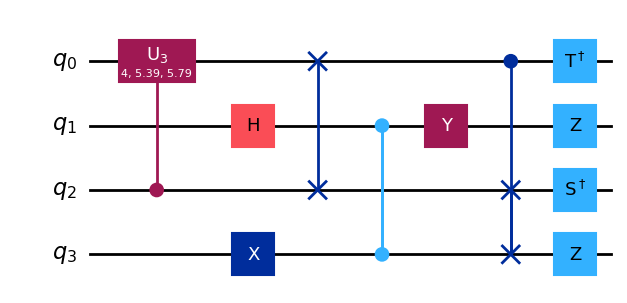

In [12]:
from qiskit.circuit.random import random_circuit

# Generate rundom circuit
N_qubits = 4
N_layers = 4
circuit = random_circuit(N_qubits, N_layers)
circuit.draw(output='mpl')

In [20]:
# Maximum number of circuit to run in paralllel. Use on real QPU
N_circuits = len(snake_qubit_inds) // N_qubits

# Number of circuits to be able to simulate classically. Use for test.
N_circuits = 3

#  Number of occupied qubits
N_qubits_tot = N_circuits*N_qubits

# Indices of qubits in the "snake" which we use for running the cirquits
snake_qubit_inds_active = snake_qubit_inds[:N_qubits_tot]
# Subgroups to encode the circuit instances in parallel
qubit_subgroups = snake_qubit_inds_active.reshape(-1,N_qubits)

In [24]:
# Combine instances of circuits to one large circuit

# Number of classical bits
N_c_bits = max(snake_qubit_inds_active)+1
full_circ = QuantumCircuit(N_qubits_tot, N_c_bits)

# Stack circuits
for i in range(N_circuits):
    full_circ.append(circuit, range(i*N_qubits,(i+1)*N_qubits))

# Fit into QPU with optimisation of the circuit
t_qc = transpile(
  full_circ,
  backend_sim_brisbane,
  initial_layout=snake_qubit_inds_active,
  optimization_level=3,
)

# Measure qubits outputs to cbits at specific locations to be able to interprete the result
for qubit_subgroup in qubit_subgroups:
    t_qc.measure(qubit_subgroup, (N_c_bits - qubit_subgroup - 1)[::-1])

/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viach

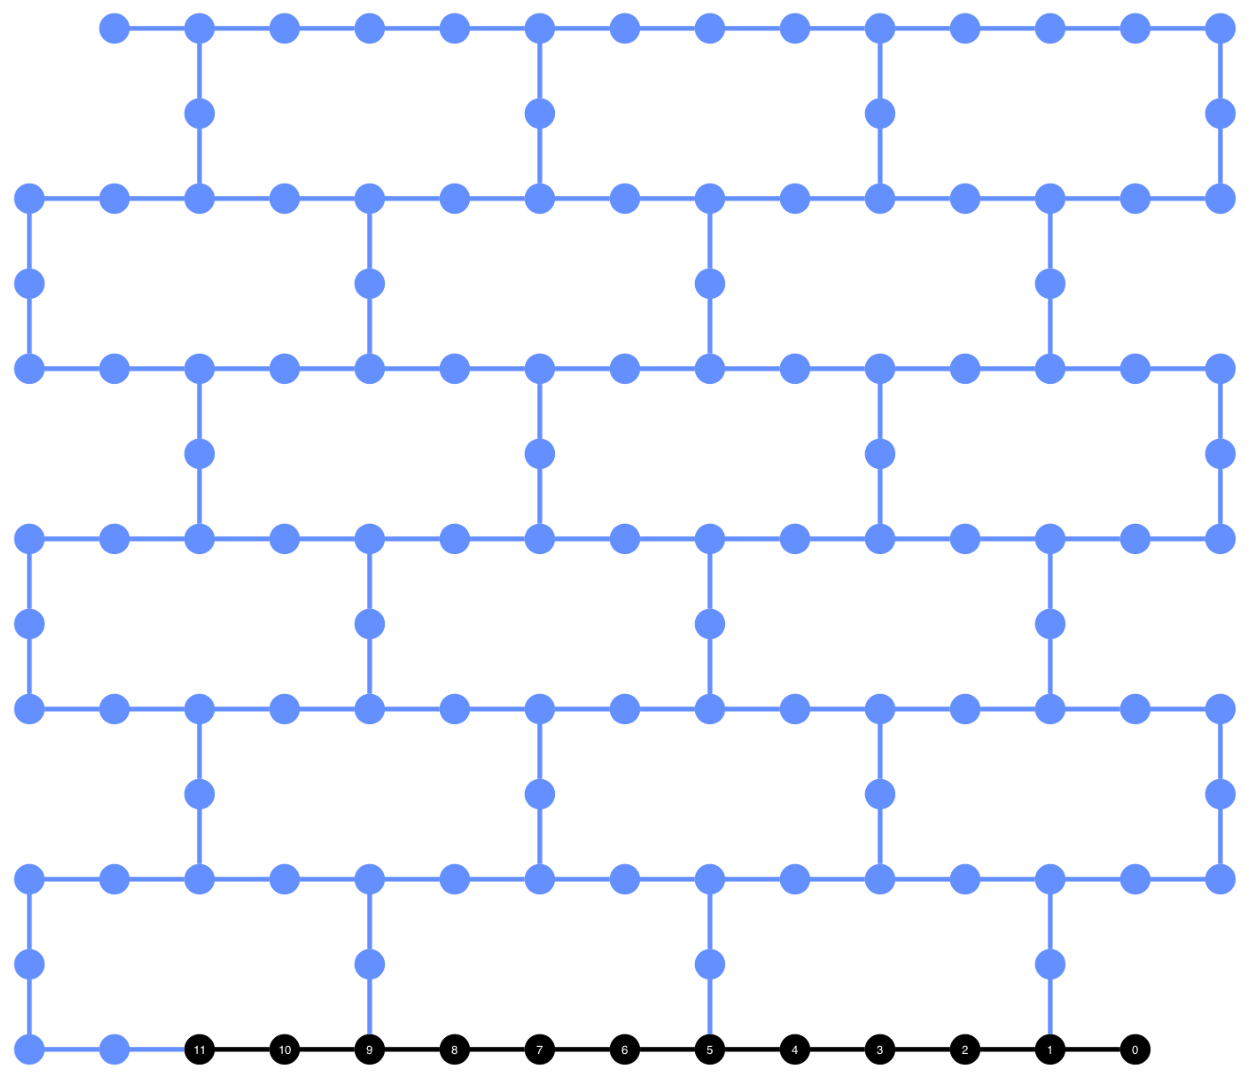

In [26]:
# Here we see which qubits we occupied
plot_circuit_layout(t_qc, backend_sim_brisbane)

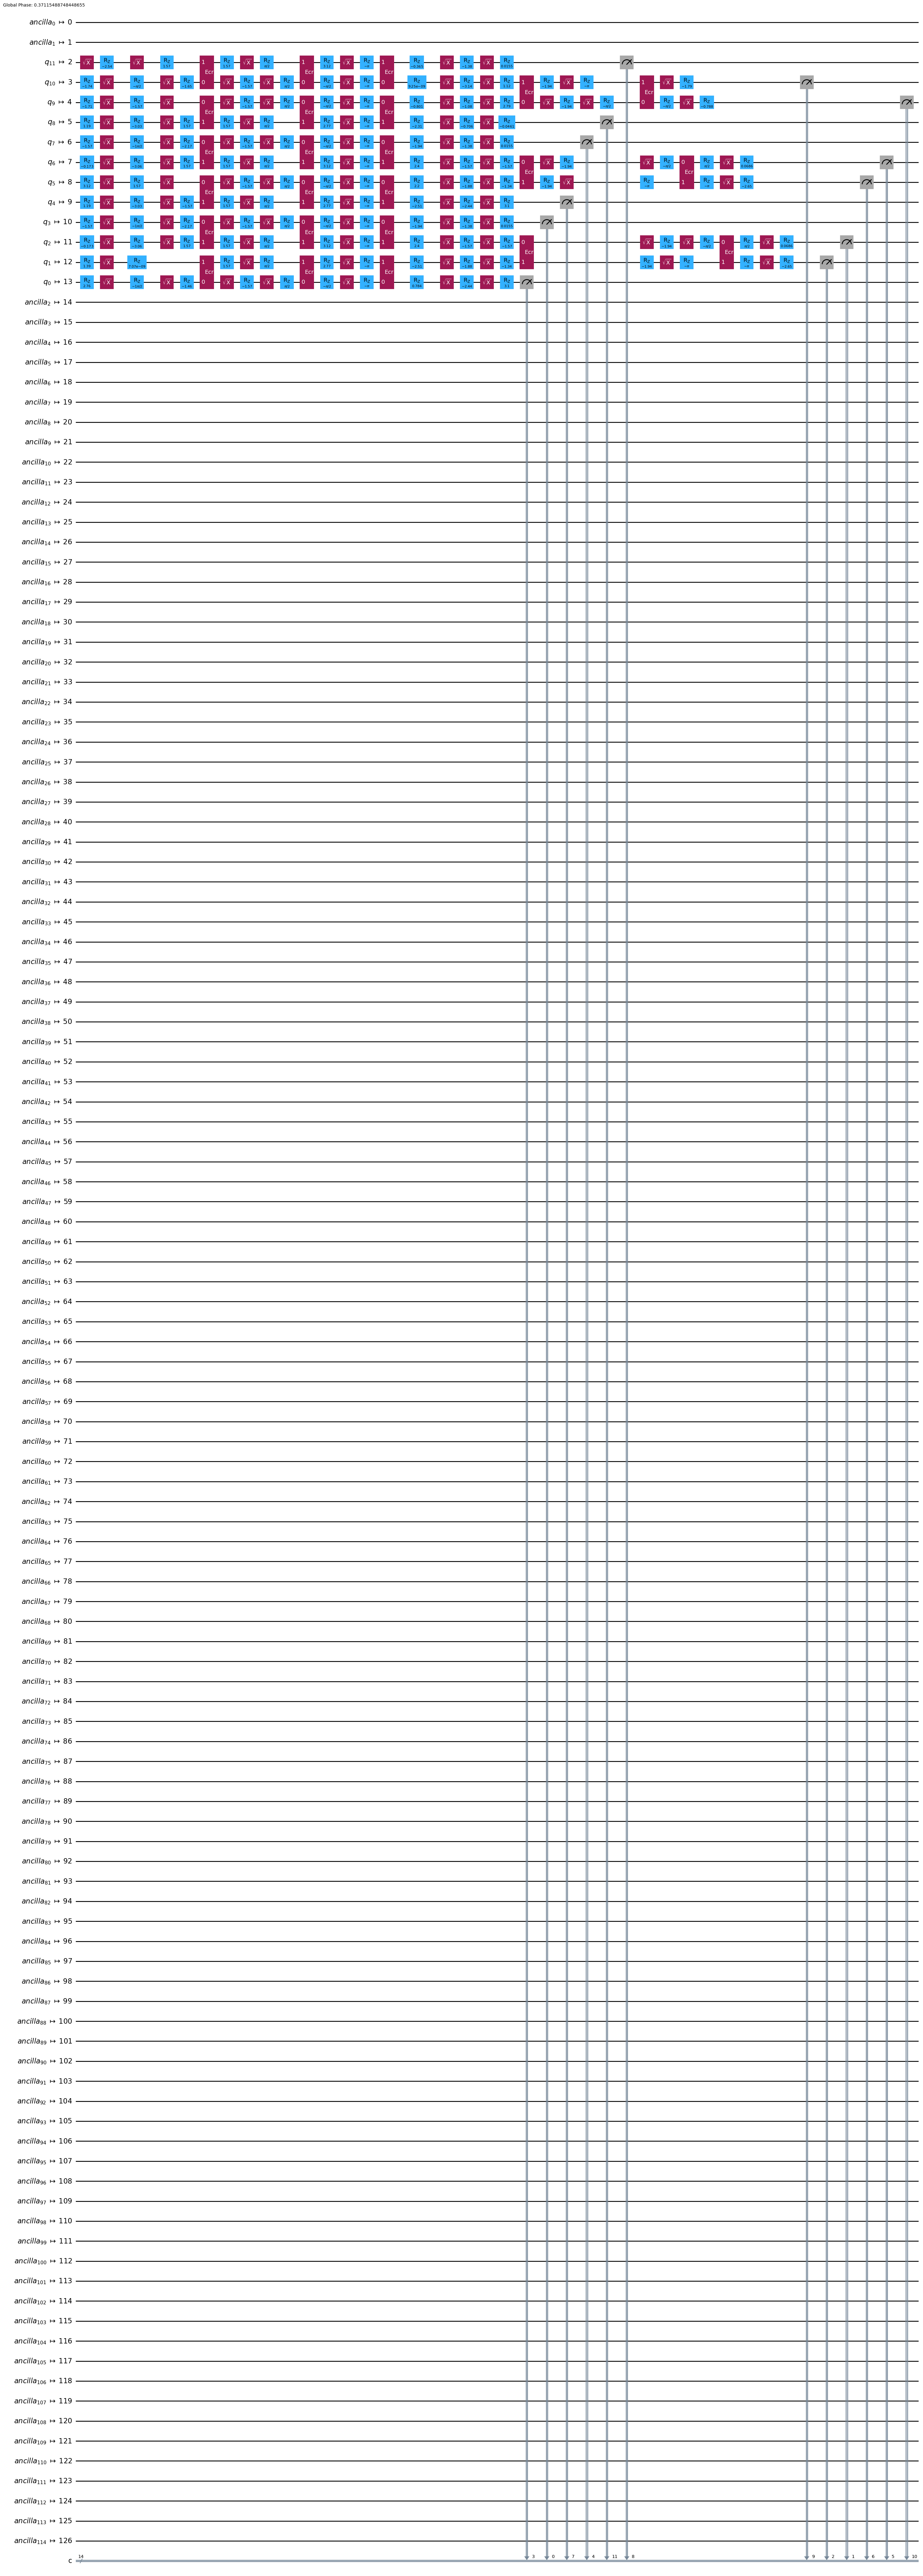

In [146]:
# This is our circuit
t_qc.draw("mpl",fold = 1000000)

# Running and analysing the result

In [27]:
# Full quasidistribution of shots for the subbmitted compiled cirquit
quasi_dist = sampler_sim_brisbane.run(t_qc, shots = 1000).result().quasi_dists[0].binary_probabilities()
quasi_dist

{'00011101010010': 0.001,
 '00001010010011': 0.001,
 '00001010110110': 0.001,
 '00001100000010': 0.002,
 '00001100000000': 0.001,
 '00001101010001': 0.001,
 '00110100110011': 0.001,
 '00111000111000': 0.001,
 '00011000100000': 0.001,
 '00111100100001': 0.001,
 '00110100111111': 0.001,
 '00010001101011': 0.001,
 '00101000101011': 0.001,
 '00001011110010': 0.001,
 '00001000100100': 0.001,
 '00111100110010': 0.002,
 '00011011000011': 0.001,
 '00011100110100': 0.001,
 '00001001101100': 0.001,
 '00010100110010': 0.001,
 '00001000010011': 0.001,
 '00001110110000': 0.001,
 '00111100100010': 0.001,
 '00001100001101': 0.001,
 '00101100100011': 0.002,
 '00001100111100': 0.003,
 '00001110111101': 0.001,
 '00100100110000': 0.001,
 '00110100100001': 0.001,
 '00011100110001': 0.001,
 '00001001100010': 0.001,
 '00001010000001': 0.001,
 '00110100110001': 0.001,
 '00001100101000': 0.001,
 '00001011000001': 0.001,
 '00000000101101': 0.001,
 '00001100101010': 0.001,
 '00001100111000': 0.002,
 '0000101101

In [28]:
# Split the distribution to subgroups corresponding to each separate circuit 
subgroup_quasi_dists = split_quasi_dist(qubit_subgroups, quasi_dist)
subgroup_quasi_dists

[{'0100': 0.3320000000000001,
  '1100': 0.3380000000000001,
  '0110': 0.025,
  '0000': 0.069,
  '1000': 0.084,
  '0001': 0.006,
  '1111': 0.016000000000000004,
  '1101': 0.008,
  '0010': 0.019000000000000003,
  '0011': 0.008,
  '1011': 0.016,
  '0101': 0.014,
  '1010': 0.020999999999999998,
  '0111': 0.018000000000000002,
  '1110': 0.024000000000000007,
  '1001': 0.002},
 {'1010': 0.008,
  '1001': 0.002,
  '1101': 0.04400000000000001,
  '0000': 0.017000000000000008,
  '1100': 0.3880000000000001,
  '0100': 0.4090000000000001,
  '0110': 0.016,
  '1111': 0.007,
  '0011': 0.008,
  '1000': 0.016,
  '0001': 0.003,
  '1011': 0.003,
  '0111': 0.010000000000000002,
  '0010': 0.010000000000000002,
  '1110': 0.021,
  '0101': 0.038000000000000006},
 {'1110': 0.022000000000000006,
  '0100': 0.40800000000000014,
  '1100': 0.4230000000000001,
  '1011': 0.007,
  '0111': 0.011000000000000003,
  '0110': 0.018000000000000002,
  '1111': 0.014000000000000002,
  '0010': 0.02,
  '0101': 0.007,
  '1010': 0.01

In [29]:
# Correcting the measurement error for each group
backend = backend_sim_brisbane
subgroup_quasi_dists_corrected = [mesurement_error_mitigation(qubit_subgroup, quasi_dist, backend) for (qubit_subgroup, quasi_dist) in  zip(qubit_subgroups, subgroup_quasi_dists)]

In [30]:
# Convert to probabilities vectors
subgroup_prob_dists_corrected = [quasidist_bits_to_array(s, N_qubits) for s in subgroup_quasi_dists_corrected]

In [31]:
# Sum all distributions for averaging. This is done here since all the submitted are the same so we can just accumulate the shots faster. But in principle you can just submit different circuits.
quasi_dists_sum = sum_distributions(subgroup_quasi_dists_corrected)
prob_dists_sum = quasidist_bits_to_array(quasi_dists_sum, N_qubits)

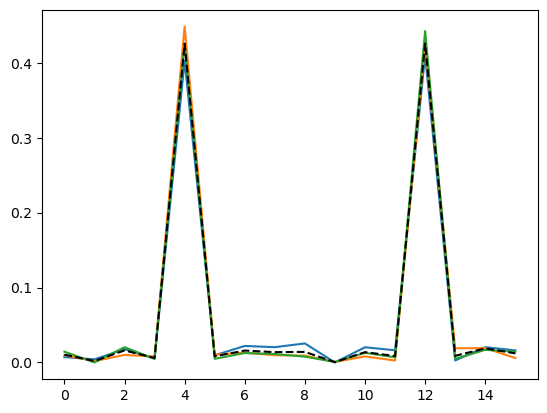

In [34]:
# See that all distributions from differen qubit groups are in fact simmilar and compare to the resulting avaraged one.
for s in subgroup_prob_dists_corrected:
    plt.plot(s)

plt.plot(prob_dists_sum, 'k--')

In [35]:
# Here we also can use the obtained avaraged distribution to obtain observables which you can use as e.g. as a loss.
quasi_dists_av = mthree.classes.ProbDistribution(quasi_dists_sum)

observables = []
for i in range(N_qubits):
    obsev = ['i']*N_qubits
    obsev[i] = 'z'
    observables += [''.join(obsev)]

[quasi_dists_av.expval(observ) for observ in observables]

[-0.004456536280385885,
 -0.8577596569864552,
 0.7905064681425881,
 0.8805045046046293]

# Simulate the 127 qubit chip sequentioully simulating the subgroups on the noisy simulator
Suppose we want to submit 27 4-qubit circuits to the IBM device. First, we want to simulate the results. Additionally, we want to account for noise specific to each subgroup instead of running all the circuits using the same subgroup, as this is not representative of reality. We cannot simulate all 4 x 27 = 108 qubits simultaneously. However, we can simulate the run of the circuits compiled to specific qubit groups sequentially.

In [40]:
# Maximum number of circuits to fit
N_circuits = len(snake_qubit_inds) // N_qubits

N_qubits_tot = N_circuits*N_qubits
snake_qubit_inds_active = snake_qubit_inds[:N_qubits_tot]
# Subgroups to encode the circuits
qubit_subgroups = snake_qubit_inds_active.reshape(-1,N_qubits)

In [41]:
# Iterate over the cirquits
N_shots = 1000
subgroup_quasi_dists = []
for qubit_subgroup in qubit_subgroups:

    # Fit into QPU
    t_qc = transpile(
      circuit,
      backend_sim_brisbane,
      initial_layout=qubit_subgroup,
      optimization_level=3,
    )
    t_qc.add_bits(ClassicalRegister(N_qubits))
    t_qc.measure(qubit_subgroup, range(N_qubits))

    subgroup_quasi_dist = sampler_sim_brisbane.run(t_qc, N_shots = 1000).result().quasi_dists[0].binary_probabilities()
    subgroup_quasi_dists += [subgroup_quasi_dist]

/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viach

In [42]:
subgroup_quasi_dists

[{'0101': 0.0107421875,
  '0111': 0.0263671875,
  '1001': 0.00390625,
  '1011': 0.0087890625,
  '0001': 0.0009765625,
  '0011': 0.0107421875,
  '1101': 0.01171875,
  '1111': 0.0185546875,
  '1010': 0.0302734375,
  '0010': 0.01953125,
  '0000': 0.0888671875,
  '1110': 0.0458984375,
  '0100': 0.3017578125,
  '1100': 0.3291015625,
  '1000': 0.0625,
  '0110': 0.0302734375},
 {'0111': 0.0087890625,
  '1110': 0.013671875,
  '1011': 0.0087890625,
  '0001': 0.001953125,
  '0011': 0.013671875,
  '1010': 0.01171875,
  '0010': 0.01171875,
  '0000': 0.009765625,
  '1111': 0.0078125,
  '1101': 0.021484375,
  '0101': 0.03515625,
  '0110': 0.017578125,
  '1100': 0.3896484375,
  '0100': 0.4296875,
  '1000': 0.0185546875},
 {'1011': 0.0068359375,
  '1001': 0.0029296875,
  '1110': 0.0166015625,
  '0011': 0.0068359375,
  '0101': 0.0078125,
  '1101': 0.0078125,
  '1111': 0.0126953125,
  '0111': 0.01171875,
  '1010': 0.0185546875,
  '0110': 0.0322265625,
  '1100': 0.4091796875,
  '0100': 0.4130859375,
  '0

In [43]:
# Correcting the measurement error for each group
backend = backend_sim_brisbane
subgroup_quasi_dists_corrected = [mesurement_error_mitigation(qubit_subgroup, quasi_dist, backend) for (qubit_subgroup, quasi_dist) in  zip(qubit_subgroups, subgroup_quasi_dists)]

In [44]:
# Convert to probabilities vectors
subgroup_prob_dists_corrected = [quasidist_bits_to_array(s, N_qubits) for s in subgroup_quasi_dists_corrected]

In [45]:
# Average all distributions
quasi_dists_sum = sum_distributions(subgroup_quasi_dists_corrected)
prob_dists_sum = quasidist_bits_to_array(quasi_dists_sum, N_qubits)

In [46]:
quasi_dists_sum

{'0000': 0.016819959492101466,
 '0001': 0.002017979227740601,
 '0010': 0.015798783528358475,
 '0011': 0.010199620964391186,
 '0100': 0.40334119551269354,
 '0101': 0.008493816295788334,
 '0110': 0.0232131907123966,
 '0111': 0.016119392499418256,
 '1000': 0.0159905074192415,
 '1001': 0.002600877297048135,
 '1010': 0.01753729038824926,
 '1011': 0.009418003757033841,
 '1100': 0.4109624285861358,
 '1101': 0.006569520176128521,
 '1110': 0.02464534527389334,
 '1111': 0.016272088869381147}

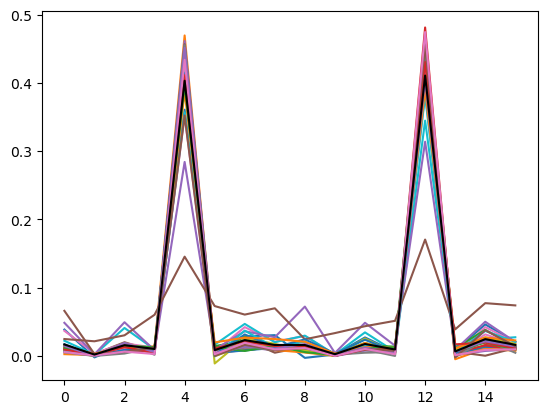

In [48]:
for s in subgroup_prob_dists_corrected:
    plt.plot(s)

plt.plot(prob_dists_sum, 'k')

In [49]:
# Convert to mthree object to obtain expected values
quasi_dists_av = mthree.classes.ProbDistribution(quasi_dists_av)

observables = []
for i in range(N_qubits):
    obsev = ['i']*N_qubits
    obsev[i] = 'z'
    observables += [''.join(obsev)]

[quasi_dists_av.expval(observ) for observ in observables]

[-0.004456536280385885,
 -0.8577596569864552,
 0.7905064681425881,
 0.8805045046046293]